In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=8/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet
/kaggle/input/jane-street-real-time-market

In [2]:
import cudf
# Load the cudf.pandas extension for pandas-like GPU acceleration
%load_ext cudf.pandas

In [3]:
import polars as pl
from glob import glob
from numba import cuda

# Directory containing the Parquet files
data_path = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet"

# Collect all Parquet file paths
parquet_files = glob(f"{data_path}/partition_id=2/part-0.parquet")

# partition_ids = [i for i in range(10)]
# parquet_files = [
#     f"{data_path}/partition_id={partition_id}/part-0.parquet"
#     for partition_id in partition_ids
# ]

# Get the number of GPUs available
available_gpus = cuda.gpus
num_gpus = len(available_gpus)

if num_gpus == 0:
    raise RuntimeError("No GPUs available for processing.")

print(f"Number of GPUs available: {num_gpus}")

# Split files evenly across available GPUs
files_per_gpu = len(parquet_files) // num_gpus
gpu_file_splits = [
    parquet_files[i * files_per_gpu : (i + 1) * files_per_gpu]
    for i in range(num_gpus)
]

# Adjust the last split to include any remaining files
if len(parquet_files) % num_gpus != 0:
    gpu_file_splits[-1].extend(parquet_files[num_gpus * files_per_gpu :])

# Function to process files on a specific GPU
def process_files_on_gpu(files, gpu_id):
    # Select the GPU for processing
    cuda.select_device(gpu_id)
    gpu_batches = []
    for file in files:
        print(f"Processing file on GPU {gpu_id}: {file}")
        
        # Read the file into GPU memory using Polars
        gpu_df = pl.read_parquet(file)
        
        # Keep all columns, no filtering
        gpu_batches.append(gpu_df)
        
        print(f"File {file} processed on GPU {gpu_id}.")

    # Concatenate all batches for this GPU into a single DataFrame
    if gpu_batches:
        return pl.concat(gpu_batches)
    else:
        return pl.DataFrame()

# Process files on all available GPUs
final_gpu_dfs = []
for gpu_id, files in enumerate(gpu_file_splits):
    gpu_df = process_files_on_gpu(files, gpu_id)
    final_gpu_dfs.append(gpu_df)

# Combine all processed batches across GPUs into a single DataFrame
final_df = pl.concat(final_gpu_dfs)

# Print summary
print(f"Final DataFrame shape on GPU: {final_df.shape}")

Number of GPUs available: 2
Processing file on GPU 1: /kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet
File /kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet processed on GPU 1.
Final DataFrame shape on GPU: (3036873, 92)


In [4]:
final_df.head()

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,…,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
340,0,0,1.902722,-0.52349,-0.131996,0.124154,-0.185518,2.011005,-0.665424,-1.030033,-1.52801,0.261375,11,7,76,-1.169775,-0.29928,-0.477456,null,-0.423311,null,-1.333162,-1.69736,0.204428,null,-0.089592,-0.207202,-0.697006,-0.771086,null,null,0.79118,-0.361479,-0.114389,null,null,…,-0.928921,null,null,-2.067725,null,-2.501255,1.346438,null,-0.946561,-0.337844,0.354287,null,null,null,null,null,-0.702601,-0.266509,-0.533959,-1.319765,-0.160904,-0.953981,null,null,0.210584,0.312869,-0.187011,-0.183416,0.251685,0.421458,0.771927,0.07199,1.426416,0.814566,-0.132949,1.183992,0.371725
340,0,1,4.090041,-0.156282,0.289095,0.193019,-0.070085,1.140459,-0.528798,-0.884754,-1.44379,0.22066,11,7,76,-0.837111,0.421702,-0.336571,null,-0.530792,null,-0.878517,-0.865011,0.83415,null,1.584139,1.088018,-0.088035,0.203477,null,null,1.462279,-0.296079,-0.364353,null,null,…,1.465106,null,null,0.999406,null,-1.427631,2.658593,null,1.788883,0.399241,0.354287,-0.232378,-0.293213,-0.304407,-1.098295,-1.787442,-0.965382,0.135424,-0.344909,-1.035528,1.161382,-0.308803,null,null,-0.240021,-0.312621,-0.338355,-0.29285,-0.199408,-0.148638,-0.796567,-0.929294,0.05538,-0.58574,-0.891481,0.184394,-0.402399
340,0,2,1.403712,-0.002521,-0.261839,-0.006259,0.041238,1.180197,-1.03497,-0.990703,-1.023218,0.242779,81,2,59,-1.094649,-0.381583,-0.515383,null,0.621933,null,-1.594152,-2.23439,-1.585274,null,-1.111434,-0.880511,-0.615049,-0.929672,null,null,0.668325,-0.378213,-0.514761,null,null,…,-1.394318,null,null,-2.148139,null,-2.872841,0.405369,null,-6.387812,-2.851222,0.354287,null,null,null,null,null,-0.934786,-0.180497,-0.628079,-0.357187,-0.363289,-0.860691,null,null,3.899125,4.003406,3.078561,2.798186,0.268406,-0.458026,-1.878922,4.185539,0.808422,0.217188,4.563775,0.802501,1.707263
340,0,3,0.904068,0.285563,0.159232,0.158522,-0.564407,1.300828,-0.625577,-0.515945,-0.97785,0.166003,4,3,11,-0.952348,0.03583,-0.6385,null,-0.386088,null,-1.722304,-1.366947,0.573252,null,-1.292146,-1.503999,0.018867,0.922218,null,null,-1.658296,-0.531493,-0.40409,null,null,…,0.575681,null,null,0.415187,null,-1.794518,2.370505,null,1.061412,0.518248,0.354287,null,null,null,null,null,-0.845495,-0.389196,-0.486743,-0.940938,0.477874,-0.355728,null,null,-0.242512,-0.122299,-1.381474,-1.028829,0.960588,0.610246,2.921769,-0.170994,1.217213,1.891398,-1.207013,0.868314,0.723984
340,0,7,1.308947,0.321869,0.21162,-0.195385,-0.358547,1.595914,-0.820045,-0.784618,-0.980539,0.141644,11,7,76,-0.616368,0.06837,-0.528482,null,0.456114,null,-1.364704,-1.394208,0.403004,null,-0.905881,0.426851,-0.080544,0.169472,null,null,-0.200466,0.608431,0.368937,null,null,…,0.264612,null,null,-1.777309,null,-1.912758,1.706022,null,-3.100237,-2.136816,0.354287,-0.399794,-0.245318,-0.427707,-1.135021,-2.254114,-0.830527,0.172057,-0.505734,-1.142089,-0.00505,-0.587971,null,null,-0.275009,-0.227588,-0.291639,-0.284915,2.084096,0.3

### Checking NaNs

In [5]:
# Check for NaN (or null) values in Polars DataFrame
null_counts = final_df.null_count()

null_counts

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,…,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85860,23,14336,20,20,0,3036873,0,0,0,0,3036873,3036873,0,0,0,3036873,33752,…,3577,100156,457856,3577,100156,20,20,33752,0,0,0,30070,18714,20499,29348,29348,0,0,0,0,0,0,33752,33752,192,192,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# List of high NaN features (> 1 million NaNs out of 47 million rows)
high_nan_features = [15, 21, 26, 27, 31, 52, 53, 55, 73, 74, 0, 1, 2, 3, 4, 39, 42, 41, 50]

# Create zero-padded feature names
drop_feats = [f"feature_{str(i).zfill(2)}" for i in high_nan_features]

# Drop the features from the DataFrame
filtered_df = final_df.drop(drop_feats)
filtered_df.head()

date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_51,feature_54,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
i16,i16,i8,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
340,0,0,1.902722,-0.665424,-1.030033,-1.52801,0.261375,11,7,76,-1.169775,-0.29928,-0.477456,-0.423311,null,-1.333162,-1.69736,0.204428,-0.089592,-0.207202,-0.697006,-0.771086,0.79118,-0.361479,-0.114389,null,null,-0.175443,-0.080401,1.368903,0.198668,0.0459,-2.47452,-2.898822,null,null,null,0.296719,-0.7349,-0.130546,-0.928921,-2.067725,-2.501255,1.346438,null,-0.946561,-0.337844,0.354287,null,null,null,null,null,-0.702601,-0.266509,-0.533959,-1.319765,-0.160904,-0.953981,0.210584,0.312869,-0.187011,-0.183416,0.251685,0.421458,0.771927,0.07199,1.426416,0.814566,-0.132949,1.183992,0.371725
340,0,1,4.090041,-0.528798,-0.884754,-1.44379,0.22066,11,7,76,-0.837111,0.421702,-0.336571,-0.530792,null,-0.878517,-0.865011,0.83415,1.584139,1.088018,-0.088035,0.203477,1.462279,-0.296079,-0.364353,null,null,-0.041622,-0.062732,-0.881672,0.00925,0.16369,0.819656,0.873064,null,-1.479233,2.186059,-0.092519,1.206873,0.350423,1.465106,0.999406,-1.427631,2.658593,null,1.788883,0.399241,0.354287,-0.232378,-0.293213,-0.304407,-1.098295,-1.787442,-0.965382,0.135424,-0.344909,-1.035528,1.161382,-0.308803,-0.240021,-0.312621,-0.338355,-0.29285,-0.199408,-0.148638,-0.796567,-0.929294,0.05538,-0.58574,-0.891481,0.184394,-0.402399
340,0,2,1.403712,-1.03497,-0.990703,-1.023218,0.242779,81,2,59,-1.094649,-0.381583,-0.515383,0.621933,null,-1.594152,-2.23439,-1.585274,-1.111434,-0.880511,-0.615049,-0.929672,0.668325,-0.378213,-0.514761,null,null,-0.313938,0.633901,2.461723,0.308924,-0.110976,0.281677,1.256042,null,null,null,-0.184656,-4.855862,-0.116942,-1.394318,-2.148139,-2.872841,0.405369,null,-6.387812,-2.851222,0.354287,null,null,null,null,null,-0.934786,-0.180497,-0.628079,-0.357187,-0.363289,-0.860691,3.899125,4.003406,3.078561,2.798186,0.268406,-0.458026,-1.878922,4.185539,0.808422,0.217188,4.563775,0.802501,1.707263
340,0,3,0.904068,-0.625577,-0.515945,-0.97785,0.166003,4,3,11,-0.952348,0.03583,-0.6385,-0.386088,null,-1.722304,-1.366947,0.573252,-1.292146,-1.503999,0.018867,0.922218,-1.658296,-0.531493,-0.40409,null,null,-1.022619,0.139672,2.735279,-0.045127,-0.041756,0.784627,0.986058,null,null,null,1.101612,4.273861,2.538638,0.575681,0.415187,-1.794518,2.370505,null,1.061412,0.518248,0.354287,null,null,null,null,null,-0.845495,-0.389196,-0.486743,-0.940938,0.477874,-0.355728,-0.242512,-0.122299,-1.381474,-1.028829,0.960588,0.610246,2.921769,-0.170994,1.217213,1.891398,-1.207013,0.868314,0.723984
340,0,7,1.308947,-0.820045,-0.784618,-0.980539,0.141644,11,7,76,-0.616368,0.06837,-0.528482,0.456114,null,-1.364704,-1.394208,0.403004,-0.905881,0.426851,-0.080544,0.169472,-0.200466,0.608431,0.368937,null,null,0.285615,0.605041,2.507432,0.126652,0.102229,0.897112,0.1843,null,-1.201433,2.674997,0.778638,0.520687,1.136911,0.264612,-1.777309,-1.912758,1.706022,null,-3.100237,-2.136816,0.354287,-0.399794,-0.245318,-0.427707,-1.135021,-2.254114,-0.830527,0.172057,-0.505734,-1.142089,-0.0050

In [7]:
filtered_df.null_count()

date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_51,feature_54,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,14336,20,20,0,0,0,0,0,0,0,0,33752,33752,0,0,0,0,0,7346,7346,103254,29348,29348,0,0,0,3577,3577,20,20,33752,0,0,0,30070,18714,20499,29348,29348,0,0,0,0,0,0,192,192,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# Fill NaNs with forward fill
filled_df = filtered_df.fill_null(strategy="forward")
filled_df = filled_df.fill_null(strategy="backward")
filled_df.head()

date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_51,feature_54,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
i16,i16,i8,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
340,0,0,1.902722,-0.665424,-1.030033,-1.52801,0.261375,11,7,76,-1.169775,-0.29928,-0.477456,-0.423311,-0.384091,-1.333162,-1.69736,0.204428,-0.089592,-0.207202,-0.697006,-0.771086,0.79118,-0.361479,-0.114389,0.459056,1.68,-0.175443,-0.080401,1.368903,0.198668,0.0459,-2.47452,-2.898822,-3.075416,-1.479233,2.186059,0.296719,-0.7349,-0.130546,-0.928921,-2.067725,-2.501255,1.346438,-0.851455,-0.946561,-0.337844,0.354287,-0.232378,-0.293213,-0.304407,-1.098295,-1.787442,-0.702601,-0.266509,-0.533959,-1.319765,-0.160904,-0.953981,0.210584,0.312869,-0.187011,-0.183416,0.251685,0.421458,0.771927,0.07199,1.426416,0.814566,-0.132949,1.183992,0.371725
340,0,1,4.090041,-0.528798,-0.884754,-1.44379,0.22066,11,7,76,-0.837111,0.421702,-0.336571,-0.530792,-0.384091,-0.878517,-0.865011,0.83415,1.584139,1.088018,-0.088035,0.203477,1.462279,-0.296079,-0.364353,0.459056,1.68,-0.041622,-0.062732,-0.881672,0.00925,0.16369,0.819656,0.873064,-3.075416,-1.479233,2.186059,-0.092519,1.206873,0.350423,1.465106,0.999406,-1.427631,2.658593,-0.851455,1.788883,0.399241,0.354287,-0.232378,-0.293213,-0.304407,-1.098295,-1.787442,-0.965382,0.135424,-0.344909,-1.035528,1.161382,-0.308803,-0.240021,-0.312621,-0.338355,-0.29285,-0.199408,-0.148638,-0.796567,-0.929294,0.05538,-0.58574,-0.891481,0.184394,-0.402399
340,0,2,1.403712,-1.03497,-0.990703,-1.023218,0.242779,81,2,59,-1.094649,-0.381583,-0.515383,0.621933,-0.384091,-1.594152,-2.23439,-1.585274,-1.111434,-0.880511,-0.615049,-0.929672,0.668325,-0.378213,-0.514761,0.459056,1.68,-0.313938,0.633901,2.461723,0.308924,-0.110976,0.281677,1.256042,-3.075416,-1.479233,2.186059,-0.184656,-4.855862,-0.116942,-1.394318,-2.148139,-2.872841,0.405369,-0.851455,-6.387812,-2.851222,0.354287,-0.232378,-0.293213,-0.304407,-1.098295,-1.787442,-0.934786,-0.180497,-0.628079,-0.357187,-0.363289,-0.860691,3.899125,4.003406,3.078561,2.798186,0.268406,-0.458026,-1.878922,4.185539,0.808422,0.217188,4.563775,0.802501,1.707263
340,0,3,0.904068,-0.625577,-0.515945,-0.97785,0.166003,4,3,11,-0.952348,0.03583,-0.6385,-0.386088,-0.384091,-1.722304,-1.366947,0.573252,-1.292146,-1.503999,0.018867,0.922218,-1.658296,-0.531493,-0.40409,0.459056,1.68,-1.022619,0.139672,2.735279,-0.045127,-0.041756,0.784627,0.986058,-3.075416,-1.479233,2.186059,1.101612,4.273861,2.538638,0.575681,0.415187,-1.794518,2.370505,-0.851455,1.061412,0.518248,0.354287,-0.232378,-0.293213,-0.304407,-1.098295,-1.787442,-0.845495,-0.389196,-0.486743,-0.940938,0.477874,-0.355728,-0.242512,-0.122299,-1.381474,-1.028829,0.960588,0.610246,2.921769,-0.170994,1.217213,1.891398,-1.207013,0.868314,0.723984
340,0,7,1.308947,-0.820045,-0.784618,-0.980539,0.141644,11,7,76,-0.616368,0.06837,-0.528482,0.456114,-0.384091,-1.364704,-1.394208,0.403004,-0.905881,0.426851,-0.080544,0.169472,-0.200466,0.608431,0.368937,0.459056,1.68,0.285615,0.605041,2.507432,0.126652,0.102229,0.897112,0.1843,-3.075416,-1.201433,2.674997,0.7

In [9]:
filled_df.null_count()

date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_51,feature_54,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Using ffill to fill missing values for time series data

In [10]:
final_df = filled_df

Preparing lagged responder values. For a given date_id and time_id, the lagged value corresponds to the same time_id but (date_id-1).

**Example:**

Current Entry (date_id = 2, time_id = 4)

Lagged Values (date_id = 1, time_id = 4)


# Creating Lagged Responders

In [11]:
import polars as pl

# List of responder columns
responder_columns = [f"responder_{i}" for i in range(9)]

# Apply the lagging for each responder column
for responder in responder_columns:
    lagged_column_name = f"{responder}_lag_1"
    final_df = final_df.with_columns(
        pl.col(responder)
        .shift(1)
        .over(["time_id", "symbol_id"])
        .alias(lagged_column_name)
    )

# Display the first few rows to verify
final_df.head()

date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_43,feature_44,feature_45,…,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
340,0,0,1.902722,-0.665424,-1.030033,-1.52801,0.261375,11,7,76,-1.169775,-0.29928,-0.477456,-0.423311,-0.384091,-1.333162,-1.69736,0.204428,-0.089592,-0.207202,-0.697006,-0.771086,0.79118,-0.361479,-0.114389,0.459056,1.68,-0.175443,-0.080401,1.368903,0.198668,0.0459,-2.47452,-2.898822,-3.075416,-1.479233,…,-0.851455,-0.946561,-0.337844,0.354287,-0.232378,-0.293213,-0.304407,-1.098295,-1.787442,-0.702601,-0.266509,-0.533959,-1.319765,-0.160904,-0.953981,0.210584,0.312869,-0.187011,-0.183416,0.251685,0.421458,0.771927,0.07199,1.426416,0.814566,-0.132949,1.183992,0.371725,null,null,null,null,null,null,null,null,null
340,0,1,4.090041,-0.528798,-0.884754,-1.44379,0.22066,11,7,76,-0.837111,0.421702,-0.336571,-0.530792,-0.384091,-0.878517,-0.865011,0.83415,1.584139,1.088018,-0.088035,0.203477,1.462279,-0.296079,-0.364353,0.459056,1.68,-0.041622,-0.062732,-0.881672,0.00925,0.16369,0.819656,0.873064,-3.075416,-1.479233,…,-0.851455,1.788883,0.399241,0.354287,-0.232378,-0.293213,-0.304407,-1.098295,-1.787442,-0.965382,0.135424,-0.344909,-1.035528,1.161382,-0.308803,-0.240021,-0.312621,-0.338355,-0.29285,-0.199408,-0.148638,-0.796567,-0.929294,0.05538,-0.58574,-0.891481,0.184394,-0.402399,null,null,null,null,null,null,null,null,null
340,0,2,1.403712,-1.03497,-0.990703,-1.023218,0.242779,81,2,59,-1.094649,-0.381583,-0.515383,0.621933,-0.384091,-1.594152,-2.23439,-1.585274,-1.111434,-0.880511,-0.615049,-0.929672,0.668325,-0.378213,-0.514761,0.459056,1.68,-0.313938,0.633901,2.461723,0.308924,-0.110976,0.281677,1.256042,-3.075416,-1.479233,…,-0.851455,-6.387812,-2.851222,0.354287,-0.232378,-0.293213,-0.304407,-1.098295,-1.787442,-0.934786,-0.180497,-0.628079,-0.357187,-0.363289,-0.860691,3.899125,4.003406,3.078561,2.798186,0.268406,-0.458026,-1.878922,4.185539,0.808422,0.217188,4.563775,0.802501,1.707263,null,null,null,null,null,null,null,null,null
340,0,3,0.904068,-0.625577,-0.515945,-0.97785,0.166003,4,3,11,-0.952348,0.03583,-0.6385,-0.386088,-0.384091,-1.722304,-1.366947,0.573252,-1.292146,-1.503999,0.018867,0.922218,-1.658296,-0.531493,-0.40409,0.459056,1.68,-1.022619,0.139672,2.735279,-0.045127,-0.041756,0.784627,0.986058,-3.075416,-1.479233,…,-0.851455,1.061412,0.518248,0.354287,-0.232378,-0.293213,-0.304407,-1.098295,-1.787442,-0.845495,-0.389196,-0.486743,-0.940938,0.477874,-0.355728,-0.242512,-0.122299,-1.381474,-1.028829,0.960588,0.610246,2.921769,-0.170994,1.217213,1.891398,-1.207013,0.868314,0.723984,null,null,null,null,null,null,null,null,null
340,0,7,1.308947,-0.820045,-0.784618,-0.980539,0.141644,11,7,76,-0.616368,0.06837,-0.528482,0.456114,-0.384091,-1.364704,-1.394208,0.403004,-0.905881,0.426851,-0.080544,0.169472,-0.200466,0.608431,0.368937,0.459056,1.68,0.285615,0.605041,2.507432,0.126652,0.102229,0.897112,0.1843,-3.075416,-1.201433,…,-0.851455,-3.100237,-2.136816,0.354287,-

In [12]:
symbol_grouped = final_df.group_by(["symbol_id"])
symbol_grouped.head()

symbol_id,date_id,time_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_43,feature_44,feature_45,…,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i8,i16,i16,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
33,340,0,1.209916,-0.633212,-0.884987,-1.116516,0.189347,11,7,76,-0.779126,3.005078,0.121433,-0.376651,-0.384091,-1.355217,-1.392789,-0.147454,-0.844224,-0.423783,-0.376668,-0.677355,-0.329561,0.004143,0.087418,0.459056,1.68,0.519162,0.885484,2.21786,0.073624,0.624836,2.513932,2.639838,-3.075416,-1.578972,…,-0.851455,-2.071329,-0.909654,0.354287,2.190872,2.202627,2.875723,-0.806243,-2.773866,-0.804561,1.363996,-0.048135,-1.040329,2.154983,0.331248,-0.332838,-0.27433,-0.116619,-0.22243,0.736711,-0.358837,-0.486845,-2.067479,-1.650616,-2.829594,-3.497808,-1.021689,-3.592558,null,null,null,null,null,null,null,null,null
33,340,1,1.209916,-0.928491,-0.811134,-0.891363,0.186566,11,7,76,-0.876049,2.253162,0.235059,-0.214921,-0.384091,-1.032542,-1.565001,-0.147454,-0.844224,-0.423783,-0.376668,-0.677355,-0.329561,0.004143,0.087418,0.459056,1.68,0.954073,1.347442,2.640027,0.095026,0.560791,2.127937,3.31816,-3.075416,-1.455334,…,-0.851455,-2.024183,-0.927673,0.354287,3.348456,3.270369,5.423163,-1.198284,-2.833378,-0.718414,1.625088,-0.055529,-0.499456,3.980979,0.504056,-0.285996,-0.330385,-0.350686,-0.300951,0.696611,-0.375397,-0.992645,-2.482374,-0.914895,-2.341006,-2.612484,-1.41632,-1.9654,null,null,null,null,null,null,null,null,null
33,340,2,1.209916,-0.526804,-1.707661,-0.86526,0.223197,11,7,76,-0.819109,2.98305,0.400843,-0.363771,-0.384091,-0.748228,-1.986952,-0.147454,-0.844224,-0.423783,-0.376668,-0.677355,-0.329561,0.004143,0.087418,0.459056,1.68,0.384331,1.127436,2.877585,0.103427,0.445859,2.871034,2.475787,-3.075416,-1.431164,…,-0.851455,-1.362841,-0.746805,0.354287,3.263024,3.09965,3.809963,-1.543409,-2.321668,-0.754108,0.727702,-0.08326,-0.485889,3.026576,0.53509,-0.234009,-0.314316,-0.34721,-0.45925,-0.600935,-0.372636,-1.051412,-3.22115,-1.251491,-1.880291,-2.952119,-1.074989,-3.164197,null,null,null,null,null,null,null,null,null
33,340,3,1.209916,-1.115988,-2.494015,-1.845924,0.285933,11,7,76,-0.981894,2.322372,0.264518,0.043621,-0.384091,-1.484597,-1.883957,-0.147454,-0.844224,-0.423783,-0.376668,-0.677355,-0.329561,0.004143,0.087418,0.459056,1.68,0.758504,1.097801,2.764683,0.089916,0.635799,2.796961,2.746741,-3.075416,-1.684831,…,-0.851455,-0.646315,-0.724432,0.354287,2.678848,2.31313,4.379071,-0.777459,-3.184853,-0.560313,0.438118,-0.089353,-0.673566,2.980289,0.96689,-0.252009,-0.324874,-0.274305,-0.3503,0.551703,-0.393916,-1.478412,-2.101955,-0.987392,-2.494569,-2.566582,-0.65504,-1.973171,null,null,null,null,null,null,null,null,null
33,340,4,1.209916,-1.63925,-6.254496,-3.339686,0.510945,11,7,76,-0.746035,1.054909,0.3233,0.141133,-0.088859,-1.091728,-0.947196,-0.147454,-0.844224,-0.423783,-0.376668,-0.677355,-0.329561,0.004143,0.087418,0.459056,1.68,0.349196,1.043039,2.836419,0.086625,0.550129,2.804078,2.327321,-3.075416,-1.97688,…,-0.851455,-0.526363,-0.823287,0.354

# Validating lags
- Plotting original responder vs lagged values

In [13]:
plot_data = final_df.group_by(["symbol_id"])

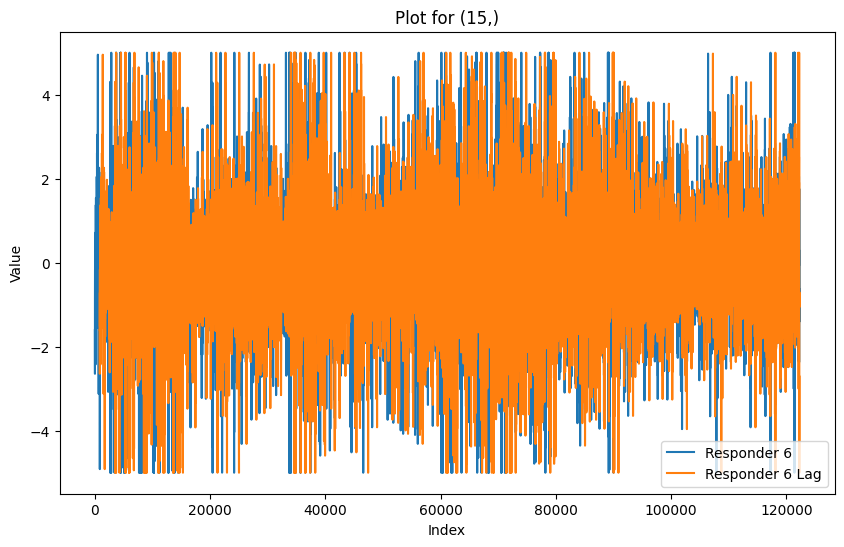

In [14]:
import matplotlib.pyplot as plt

# Assuming `plot_data` is a list of tuples (column_name, Polars DataFrame)
for c, i in plot_data:
    # Convert the Polars DataFrame to a pandas DataFrame for plotting
    i_pandas = i.to_pandas()
    
    # Plot the columns
    plt.figure(figsize=(10, 6))
    i_pandas["responder_6"].plot(label="Responder 6", legend=True)
    i_pandas["responder_6_lag_1"].plot(label="Responder 6 Lag", legend=True)
    plt.title(f"Plot for {c}")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
    break
    


# Training

## LSTM Model
- Use past 10 entries to predict the 11th value
- Separate time series for each symbol

In [15]:
# Assume `final_df` is a polars DataFrame
df = final_df.clone()

df = df.drop_nulls()

In [16]:
df.null_count()

date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_43,feature_44,feature_45,…,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
df = df.filter(
    pl.col("symbol_id") == 21
)

In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler


# Define features and target
feature_columns = [col for col in df.columns if col.startswith('feature_') or col.endswith("lag_1")]
target_column = 'responder_6'

# Extract features and target
X = df[feature_columns].to_numpy()
y = df[target_column].to_numpy().flatten()

# # Normalize features and target
# scaler_X = StandardScaler()
# X = scaler_X.fit_transform(X)

# scaler_y = StandardScaler()
# y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

from tqdm import tqdm

def create_sequences_gpu(X, y, time_steps=10, device="cuda:1"):
    """
    Creates sequences using GPU for faster processing.
    Args:
        X (numpy.ndarray): Feature array.
        y (numpy.ndarray): Target array.
        time_steps (int): Number of timesteps for sequence.
        device (str): Device to use ("cuda" for GPU, "cpu" for CPU).
    Returns:
        torch.Tensor, torch.Tensor: Feature sequences and corresponding targets.
    """
    # Convert data to PyTorch tensors and move to the specified device
    X_tensor = torch.tensor(X, dtype=torch.float16, device=device)
    y_tensor = torch.tensor(y, dtype=torch.float16, device=device)
    
    # Number of sequences
    n_sequences = len(X) - time_steps
    
    # Create sequences using tensor slicing
    X_seq = torch.stack([X_tensor[i:i+time_steps] for i in tqdm(range(n_sequences), desc="Creating Sequences on GPU")])
    y_seq = y_tensor[time_steps:]  # Corresponding targets start after the first time_steps
    
    return X_seq, y_seq

# Create sequences
time_steps = 10
X_seq, y_seq = create_sequences_gpu(X, y, time_steps)

Creating Sequences on GPU: 100%|██████████| 19517/19517 [00:00<00:00, 246811.54it/s]


In [19]:
from torch.cuda.amp import autocast, GradScaler

# Initialize GradScaler
scaler = GradScaler()

# Define a PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.batch_norm = nn.BatchNorm1d(hidden_size // 2)  # BatchNorm for the hidden layer
        self.fc2 = nn.Linear(hidden_size // 2, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(out[:, -1, :])  # Take the last time step
        
        # Apply batch normalization
        out = self.batch_norm(out)
        
        out = self.fc2(out)
        out = 5 * torch.tanh(out)  # Scale tanh output to [-5, +5]
        return out

# Cross-validation setup
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=False)

# Training parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_size = X_seq.shape[2]
hidden_size = 128
num_layers = 3
batch_size = 128
num_epochs = 15
learning_rate = 0.008

mse_scores = []
r2_scores = []

from tqdm import tqdm  # Import tqdm for progress bars

for fold, (train_index, test_index) in enumerate(kf.split(X_seq)):
    print(f"\nStarting Fold {fold + 1}/{n_splits}")

    # Split the data into train and test sets
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # Create Datasets and DataLoaders
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)

    # model = model.half()  # Use float16 for the model

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop with progress bar
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        with tqdm(total=len(train_loader), desc=f"Fold {fold + 1} Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                optimizer.zero_grad()

               # Forward pass with autocasting
                with autocast():
                    outputs = model(X_batch)
                    loss = criterion(outputs.squeeze(), y_batch)
                    if torch.isnan(loss) or torch.isnan(outputs).any():
                        print("NaNs detected in loss or outputs")
                        break
    
                # Backward pass and optimization with scaling
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                # Update loss and progress bar
                epoch_loss += loss.item()
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {epoch_loss / len(train_loader):.4f}")

    # Evaluate the model
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with autocast():
                outputs = model(X_batch)
                y_true.extend(y_batch.cpu().numpy())
                y_pred.extend(outputs.squeeze().cpu().numpy())

    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Fold {fold + 1} Mean Squared Error: {mse:.4f}")
    print(f"Fold {fold + 1} R-squared: {r2:.4f}")

    mse_scores.append(mse)
    r2_scores.append(r2)

# Calculate and print the average scores
avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)

print("\nCross-Validation Results:")
print(f"Average Mean Squared Error over {n_splits} folds: {avg_mse:.4f}")
print(f"Average R-squared over {n_splits} folds: {avg_r2:.4f}")


/tmp/ipykernel_23/1473430177.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Starting Fold 1/5


Fold 1 Epoch 1/15:   0%|          | 0/122 [00:00<?, ?batch/s]/tmp/ipykernel_23/1473430177.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 1 Epoch 1/15: 100%|██████████| 122/122 [00:01<00:00, 67.86batch/s, Loss=0.2871] 


Epoch [1/15], Average Loss: 1.2972


Fold 1 Epoch 2/15: 100%|██████████| 122/122 [00:01<00:00, 111.70batch/s, Loss=0.2888]


Epoch [2/15], Average Loss: 0.8595


Fold 1 Epoch 3/15: 100%|██████████| 122/122 [00:01<00:00, 104.86batch/s, Loss=0.2911]


Epoch [3/15], Average Loss: 0.8545


Fold 1 Epoch 4/15: 100%|██████████| 122/122 [00:01<00:00, 96.02batch/s, Loss=0.2894]


Epoch [4/15], Average Loss: 0.8536


Fold 1 Epoch 5/15: 100%|██████████| 122/122 [00:01<00:00, 108.77batch/s, Loss=0.2998]


Epoch [5/15], Average Loss: 0.8621


Fold 1 Epoch 6/15: 100%|██████████| 122/122 [00:01<00:00, 111.73batch/s, Loss=0.2901]


Epoch [6/15], Average Loss: 0.8621


Fold 1 Epoch 7/15: 100%|██████████| 122/122 [00:01<00:00, 110.31batch/s, Loss=0.2902]


Epoch [7/15], Average Loss: 0.8540


Fold 1 Epoch 8/15: 100%|██████████| 122/122 [00:01<00:00, 110.85batch/s, Loss=0.2894]


Epoch [8/15], Average Loss: 0.8543


Fold 1 Epoch 9/15: 100%|██████████| 122/122 [00:01<00:00, 108.69batch/s, Loss=0.2890]


Epoch [9/15], Average Loss: 0.8550


Fold 1 Epoch 10/15: 100%|██████████| 122/122 [00:01<00:00, 111.06batch/s, Loss=0.2879]


Epoch [10/15], Average Loss: 0.8557


Fold 1 Epoch 11/15: 100%|██████████| 122/122 [00:01<00:00, 110.09batch/s, Loss=0.2882]


Epoch [11/15], Average Loss: 0.8569


Fold 1 Epoch 12/15: 100%|██████████| 122/122 [00:01<00:00, 108.11batch/s, Loss=0.2883]


Epoch [12/15], Average Loss: 0.8566


Fold 1 Epoch 13/15: 100%|██████████| 122/122 [00:01<00:00, 111.13batch/s, Loss=0.2885]


Epoch [13/15], Average Loss: 0.8568


Fold 1 Epoch 14/15: 100%|██████████| 122/122 [00:01<00:00, 111.63batch/s, Loss=0.2892]


Epoch [14/15], Average Loss: 0.8577


Fold 1 Epoch 15/15: 100%|██████████| 122/122 [00:01<00:00, 112.72batch/s, Loss=0.2884]
/tmp/ipykernel_23/1473430177.py:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [15/15], Average Loss: 0.8572
Fold 1 Mean Squared Error: 0.9619
Fold 1 R-squared: -0.5336

Starting Fold 2/5


Fold 2 Epoch 1/15:   0%|          | 0/122 [00:00<?, ?batch/s]/tmp/ipykernel_23/1473430177.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 2 Epoch 1/15: 100%|██████████| 122/122 [00:01<00:00, 112.85batch/s, Loss=0.2868]


Epoch [1/15], Average Loss: 0.9564


Fold 2 Epoch 2/15: 100%|██████████| 122/122 [00:01<00:00, 109.44batch/s, Loss=0.2880]


Epoch [2/15], Average Loss: 0.7035


Fold 2 Epoch 3/15: 100%|██████████| 122/122 [00:01<00:00, 112.21batch/s, Loss=0.2893]


Epoch [3/15], Average Loss: 0.6999


Fold 2 Epoch 4/15: 100%|██████████| 122/122 [00:01<00:00, 110.84batch/s, Loss=0.2896]


Epoch [4/15], Average Loss: 0.6990


Fold 2 Epoch 5/15: 100%|██████████| 122/122 [00:01<00:00, 111.34batch/s, Loss=0.2895]


Epoch [5/15], Average Loss: 0.6989


Fold 2 Epoch 6/15: 100%|██████████| 122/122 [00:01<00:00, 107.70batch/s, Loss=0.2893]


Epoch [6/15], Average Loss: 0.6990


Fold 2 Epoch 7/15: 100%|██████████| 122/122 [00:01<00:00, 109.46batch/s, Loss=0.2889]


Epoch [7/15], Average Loss: 0.6992


Fold 2 Epoch 8/15: 100%|██████████| 122/122 [00:01<00:00, 111.51batch/s, Loss=0.2886]


Epoch [8/15], Average Loss: 0.6995


Fold 2 Epoch 9/15: 100%|██████████| 122/122 [00:01<00:00, 110.21batch/s, Loss=0.2882]


Epoch [9/15], Average Loss: 0.6998


Fold 2 Epoch 10/15: 100%|██████████| 122/122 [00:01<00:00, 108.31batch/s, Loss=0.2879]


Epoch [10/15], Average Loss: 0.7002


Fold 2 Epoch 11/15: 100%|██████████| 122/122 [00:01<00:00, 108.31batch/s, Loss=0.2878]


Epoch [11/15], Average Loss: 0.7007


Fold 2 Epoch 12/15: 100%|██████████| 122/122 [00:01<00:00, 110.24batch/s, Loss=0.2877]


Epoch [12/15], Average Loss: 0.7009


Fold 2 Epoch 13/15: 100%|██████████| 122/122 [00:01<00:00, 110.47batch/s, Loss=0.2881]


Epoch [13/15], Average Loss: 0.7015


Fold 2 Epoch 14/15: 100%|██████████| 122/122 [00:01<00:00, 111.03batch/s, Loss=0.2890]


Epoch [14/15], Average Loss: 0.7018


Fold 2 Epoch 15/15: 100%|██████████| 122/122 [00:01<00:00, 105.98batch/s, Loss=0.2892]
/tmp/ipykernel_23/1473430177.py:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [15/15], Average Loss: 0.7013
Fold 2 Mean Squared Error: 18.9375
Fold 2 R-squared: -14.4349

Starting Fold 3/5


Fold 3 Epoch 1/15:   0%|          | 0/122 [00:00<?, ?batch/s]/tmp/ipykernel_23/1473430177.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 3 Epoch 1/15: 100%|██████████| 122/122 [00:01<00:00, 110.96batch/s, Loss=0.2882]


Epoch [1/15], Average Loss: 1.1433


Fold 3 Epoch 2/15: 100%|██████████| 122/122 [00:01<00:00, 98.37batch/s, Loss=0.2905]


Epoch [2/15], Average Loss: 0.8680


Fold 3 Epoch 3/15: 100%|██████████| 122/122 [00:01<00:00, 108.10batch/s, Loss=0.2924]


Epoch [3/15], Average Loss: 0.8643


Fold 3 Epoch 4/15: 100%|██████████| 122/122 [00:01<00:00, 112.04batch/s, Loss=0.2912]


Epoch [4/15], Average Loss: 0.8635


Fold 3 Epoch 5/15: 100%|██████████| 122/122 [00:01<00:00, 111.98batch/s, Loss=0.2902]


Epoch [5/15], Average Loss: 0.8641


Fold 3 Epoch 6/15: 100%|██████████| 122/122 [00:01<00:00, 112.01batch/s, Loss=0.2905]


Epoch [6/15], Average Loss: 0.8640


Fold 3 Epoch 7/15: 100%|██████████| 122/122 [00:01<00:00, 110.26batch/s, Loss=0.2916]


Epoch [7/15], Average Loss: 0.8646


Fold 3 Epoch 8/15: 100%|██████████| 122/122 [00:01<00:00, 110.84batch/s, Loss=0.2917]


Epoch [8/15], Average Loss: 0.8640


Fold 3 Epoch 9/15: 100%|██████████| 122/122 [00:01<00:00, 107.09batch/s, Loss=0.2904]


Epoch [9/15], Average Loss: 0.8643


Fold 3 Epoch 10/15: 100%|██████████| 122/122 [00:01<00:00, 109.84batch/s, Loss=0.3481]


Epoch [10/15], Average Loss: 0.9048


Fold 3 Epoch 11/15: 100%|██████████| 122/122 [00:01<00:00, 110.54batch/s, Loss=0.2862]


Epoch [11/15], Average Loss: 0.8923


Fold 3 Epoch 12/15: 100%|██████████| 122/122 [00:01<00:00, 111.18batch/s, Loss=0.2897]


Epoch [12/15], Average Loss: 0.8676


Fold 3 Epoch 13/15: 100%|██████████| 122/122 [00:01<00:00, 110.73batch/s, Loss=0.2908]


Epoch [13/15], Average Loss: 0.8640


Fold 3 Epoch 14/15: 100%|██████████| 122/122 [00:01<00:00, 110.55batch/s, Loss=0.2913]


Epoch [14/15], Average Loss: 0.8638


Fold 3 Epoch 15/15: 100%|██████████| 122/122 [00:01<00:00, 110.13batch/s, Loss=0.2911]
/tmp/ipykernel_23/1473430177.py:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [15/15], Average Loss: 0.8637
Fold 3 Mean Squared Error: 1.0664
Fold 3 R-squared: -0.8194

Starting Fold 4/5


Fold 4 Epoch 1/15:   0%|          | 0/122 [00:00<?, ?batch/s]/tmp/ipykernel_23/1473430177.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 4 Epoch 1/15: 100%|██████████| 122/122 [00:01<00:00, 112.68batch/s, Loss=0.2853]


Epoch [1/15], Average Loss: 1.1033


Fold 4 Epoch 2/15: 100%|██████████| 122/122 [00:01<00:00, 108.26batch/s, Loss=0.2882]


Epoch [2/15], Average Loss: 0.8712


Fold 4 Epoch 3/15: 100%|██████████| 122/122 [00:01<00:00, 108.92batch/s, Loss=0.2926]


Epoch [3/15], Average Loss: 0.8666


Fold 4 Epoch 4/15: 100%|██████████| 122/122 [00:01<00:00, 110.57batch/s, Loss=0.2920]


Epoch [4/15], Average Loss: 0.8649


Fold 4 Epoch 5/15: 100%|██████████| 122/122 [00:01<00:00, 112.54batch/s, Loss=0.2856]


Epoch [5/15], Average Loss: 0.8667


Fold 4 Epoch 6/15: 100%|██████████| 122/122 [00:01<00:00, 112.57batch/s, Loss=0.2853]


Epoch [6/15], Average Loss: 0.8695


Fold 4 Epoch 7/15: 100%|██████████| 122/122 [00:01<00:00, 109.05batch/s, Loss=0.2853]


Epoch [7/15], Average Loss: 0.8701


Fold 4 Epoch 8/15: 100%|██████████| 122/122 [00:01<00:00, 108.43batch/s, Loss=0.2854]


Epoch [8/15], Average Loss: 0.8712


Fold 4 Epoch 9/15: 100%|██████████| 122/122 [00:01<00:00, 111.03batch/s, Loss=0.2868]


Epoch [9/15], Average Loss: 0.8738


Fold 4 Epoch 10/15: 100%|██████████| 122/122 [00:01<00:00, 110.99batch/s, Loss=0.2859]


Epoch [10/15], Average Loss: 0.8742


Fold 4 Epoch 11/15: 100%|██████████| 122/122 [00:01<00:00, 109.51batch/s, Loss=0.2871]


Epoch [11/15], Average Loss: 0.8750


Fold 4 Epoch 12/15: 100%|██████████| 122/122 [00:01<00:00, 109.17batch/s, Loss=0.2867]


Epoch [12/15], Average Loss: 0.8757


Fold 4 Epoch 13/15: 100%|██████████| 122/122 [00:01<00:00, 110.16batch/s, Loss=0.2870]


Epoch [13/15], Average Loss: 0.8754


Fold 4 Epoch 14/15: 100%|██████████| 122/122 [00:01<00:00, 109.45batch/s, Loss=0.2880]


Epoch [14/15], Average Loss: 0.8757


Fold 4 Epoch 15/15: 100%|██████████| 122/122 [00:01<00:00, 100.91batch/s, Loss=0.2876]
/tmp/ipykernel_23/1473430177.py:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [15/15], Average Loss: 0.8756
Fold 4 Mean Squared Error: 21.7656
Fold 4 R-squared: -36.6904

Starting Fold 5/5


Fold 5 Epoch 1/15:   0%|          | 0/122 [00:00<?, ?batch/s]/tmp/ipykernel_23/1473430177.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 5 Epoch 1/15: 100%|██████████| 122/122 [00:01<00:00, 100.30batch/s, Loss=0.2641]


Epoch [1/15], Average Loss: 1.1260


Fold 5 Epoch 2/15: 100%|██████████| 122/122 [00:01<00:00, 111.21batch/s, Loss=0.2657]


Epoch [2/15], Average Loss: 0.7678


Fold 5 Epoch 3/15: 100%|██████████| 122/122 [00:01<00:00, 109.68batch/s, Loss=0.2637]


Epoch [3/15], Average Loss: 0.7641


Fold 5 Epoch 4/15: 100%|██████████| 122/122 [00:01<00:00, 112.48batch/s, Loss=0.2634]


Epoch [4/15], Average Loss: 0.7631


Fold 5 Epoch 5/15: 100%|██████████| 122/122 [00:01<00:00, 106.97batch/s, Loss=0.2634]


Epoch [5/15], Average Loss: 0.7629


Fold 5 Epoch 6/15: 100%|██████████| 122/122 [00:01<00:00, 110.50batch/s, Loss=0.2636]


Epoch [6/15], Average Loss: 0.7629


Fold 5 Epoch 7/15: 100%|██████████| 122/122 [00:01<00:00, 110.67batch/s, Loss=0.2666]


Epoch [7/15], Average Loss: 0.7630


Fold 5 Epoch 8/15: 100%|██████████| 122/122 [00:01<00:00, 108.62batch/s, Loss=0.2734]


Epoch [8/15], Average Loss: 0.7638


Fold 5 Epoch 9/15: 100%|██████████| 122/122 [00:01<00:00, 110.77batch/s, Loss=0.2778]


Epoch [9/15], Average Loss: 0.7662


Fold 5 Epoch 10/15: 100%|██████████| 122/122 [00:01<00:00, 107.86batch/s, Loss=0.2786]


Epoch [10/15], Average Loss: 0.7675


Fold 5 Epoch 11/15: 100%|██████████| 122/122 [00:01<00:00, 110.81batch/s, Loss=0.2846]


Epoch [11/15], Average Loss: 0.7682


Fold 5 Epoch 12/15: 100%|██████████| 122/122 [00:01<00:00, 110.56batch/s, Loss=0.2894]


Epoch [12/15], Average Loss: 0.7701


Fold 5 Epoch 13/15: 100%|██████████| 122/122 [00:01<00:00, 111.36batch/s, Loss=0.2897]


Epoch [13/15], Average Loss: 0.7727


Fold 5 Epoch 14/15: 100%|██████████| 122/122 [00:01<00:00, 107.93batch/s, Loss=0.2901]


Epoch [14/15], Average Loss: 0.7755


Fold 5 Epoch 15/15: 100%|██████████| 122/122 [00:01<00:00, 110.76batch/s, Loss=0.2896]
/tmp/ipykernel_23/1473430177.py:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [15/15], Average Loss: 0.7755
Fold 5 Mean Squared Error: 17.5469
Fold 5 R-squared: -17.1007

Cross-Validation Results:
Average Mean Squared Error over 5 folds: 12.0547
Average R-squared over 5 folds: -13.9158


In [20]:
y_true, y_pred = [], []
with autocast():
    outputs = model(X_batch)
    y_true.extend(y_batch.cpu().numpy())
    y_pred.extend(outputs.squeeze().detach().cpu().numpy())

/tmp/ipykernel_23/4008034385.py:2: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


In [21]:
# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Fold {fold + 1} Mean Squared Error: {mse:.4f}")
print(f"Fold {fold + 1} R-squared: {r2:.4f}")

Fold 5 Mean Squared Error: 16.7500
Fold 5 R-squared: -260.3070


In [22]:
if torch.isnan(X_batch).any():
    print("NaN values found in X_batch")

In [23]:
outputs

tensor([[-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.0078],
        [-4.